### Content

### 1.  Mounting the google drive to google colab

In [1]:
# mounting the my googledrive to google.colab
# this is needed to save my weights, Neural Network model while it is running
# the model, weights can be accessed at a later time if google colab disconnects

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 2. Standard Imports for Recurrent Neural Networks

In [2]:
from __future__ import print_function

# For preprocessing the text into integer(ids)
# For plotting the accuracy and loss curve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# regular expression to proprocess raw_text
import regex as re

# To instantiate Recurrent Neural Networks
from keras.models import Sequential
# My model will be dense with all the nodes to 'touch'
from keras.layers import Dense, Activation
# LSTM, GRU
from keras.layers import LSTM, GRU
#from keras.optimizers import RMSprop, adam

# to create a callback, this will be a checkpoint
from keras.callbacks import LambdaCallback

# need to create a random seed to create a text, so the model will learn the sequence
import random
import sys
import io

### 3. Loading the txt file that is used fro RNN

In [3]:
# cd to pull my txt file from my google drive into google colab
%cd /content/gdrive/My Drive/Capstone/Data/

# filename called 'out.txt'
filename = "rnn_text.txt"

# extract the raw text
raw_text = open(filename, 'r', encoding='utf-8').read()


# lowercase my text
data = raw_text.lower()
# remove url links
data = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',data)
# keep letters
data = re.sub("[^a-zA-Z]", " ", data)
# strip to remove empty spaces before beginning and end of string
data = data.strip()

/content/gdrive/My Drive/Capstone/Data


### 4. Exploring text dataset

In [4]:
# set - find a list of specific characters 
# list - to convert characters into a list
# sorted - to sort list into alphabetical order
chars = sorted(list(set(data)))

# count of total characters
print('total chars: ', len(chars))

total chars:  27


In [5]:
# mapping the characters to numerical values & vice versa
# this will be crucial for feeding into our RNN model
# and required to map the predicted numerical values back to their corresponding characters

char_indices = dict((c, i) for i, c in enumerate(chars))

# noted that in this list of character mapping, there is no 'z' in text
# noted that ' ' white space is counted as a character
char_indices

{' ': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [6]:
# this will be used from mapping numerical values back to characters
indices_char = dict((i, c) for i, c in enumerate(chars))

indices_char

{0: ' ',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

### 5. Numerical encode the sentences and features

In [7]:
len(data)

1208984

In [8]:
text = data

In [9]:
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 402962


In [10]:
print(sentences[:5])
print(next_chars[:5])

['just auditing this course helped me a lot in learning this language programming  attentive save the ', 't auditing this course helped me a lot in learning this language programming  attentive save the mon', 'uditing this course helped me a lot in learning this language programming  attentive save the money ', 'ting this course helped me a lot in learning this language programming  attentive save the money i w', 'g this course helped me a lot in learning this language programming  attentive save the money i will']
['m', 'e', 'i', 'i', ' ']


In [13]:
len(text)

1208984

In [11]:
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=42, shuffle=False)

### 6. define the model topolgy
 https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6

In [14]:
# Define the model architecture 

def create_model():
    #instantial
    model = Sequential()
    model.add(LSTM(128, input_shape=(maxlen, len(chars))))
    model.add(Dense(len(chars)))
    model.add(Activation('softmax'))
    
    # Compiling the model
    # as my model are one-hot encoded, i will use categorical_crossentropy
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    
    return model

#create the model
model_ckpt= create_model()

In [15]:
model_ckpt.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               79872     
_________________________________________________________________
dense (Dense)                (None, 27)                3483      
_________________________________________________________________
activation (Activation)      (None, 27)                0         
Total params: 83,355
Trainable params: 83,355
Non-trainable params: 0
_________________________________________________________________


### 7. Creating my ModelCheckpoint and callback requirements

In [16]:
from keras.callbacks import ModelCheckpoint

# specifying where my checkpoint files will be stored
filepath = "/content/gdrive/My Drive/Capstone/Data/"

# this ModelCheckpoint save weights and save the best model as it runs
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             save_weights_only=True, save_best_only=True,
                             mode='min',verbose=1 )

In [17]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)

In [18]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [19]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [20]:
### combining all of my callbacks

callbacks = [print_callback, checkpoint, reduce_lr]

### 8.Training my RNN model

In [21]:
history = model_ckpt.fit(X_train, y_train, batch_size=128, epochs=50, validation_data =(X_test, y_test),callbacks=callbacks)

Epoch 1/50
2362/2362 [==============================] - 56s 11ms/step - loss: 2.3556 - accuracy: 0.3184 - val_loss: 1.5988 - val_accuracy: 0.5403

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "approach of not giving extra load   smoothly building up   anyone who is planning to start programmi"
approach of not giving extra load   smoothly building up   anyone who is planning to start programming                                                                                                                                                                                                                                                                                                                                                                                                              
----- diversity: 0.5
----- Generating with seed: "approach of not giving extra load   smoothly building up   anyone who is planning to start programmi"
approach of

### 9. evaluating performance of model

In [22]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [23]:
train_Loss, train_Accuracy = model_ckpt.evaluate(X_train, y_train, verbose=2)

9445/9445 - 28s - loss: 0.7912 - accuracy: 0.7586


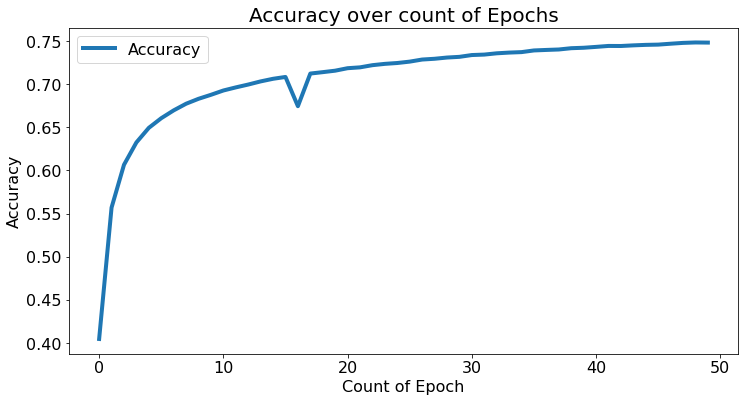

In [24]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=4)
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


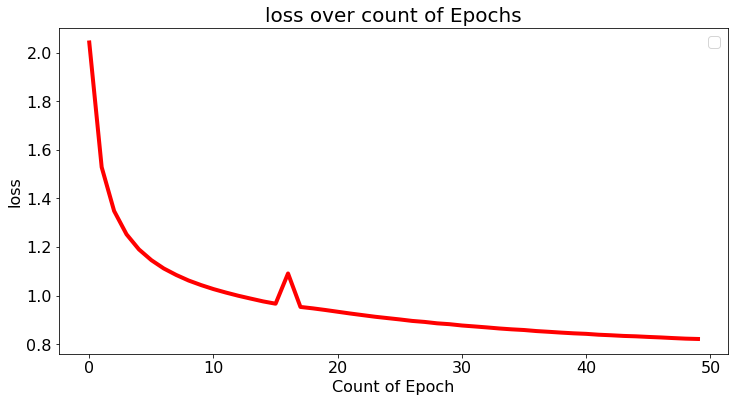

In [25]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=4, color='red')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

In [26]:
test_Loss, test_Accuracy = model_ckpt.evaluate(X_test, y_test, verbose=2)

3149/3149 - 9s - loss: 1.0349 - accuracy: 0.7039


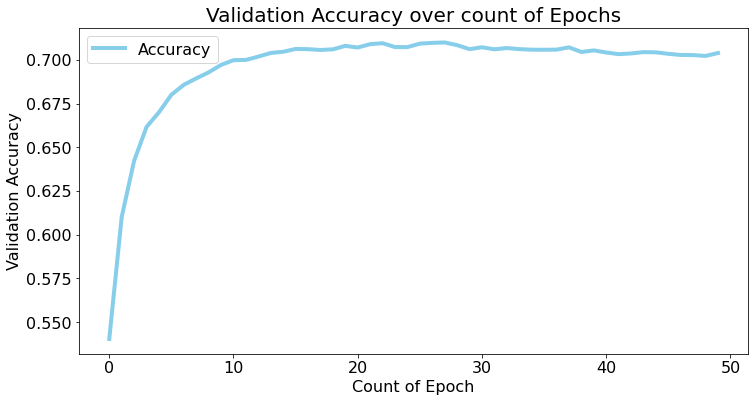

In [27]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_accuracy'], label='Accuracy', lw=4, color='skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over count of Epochs', fontsize=20)
plt.legend();

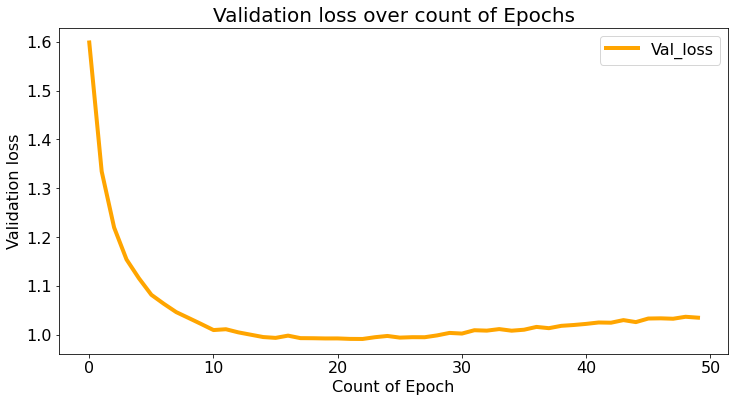

In [28]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_loss'], lw=4, label='Val_loss', color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss over count of Epochs', fontsize=20)
plt.legend();

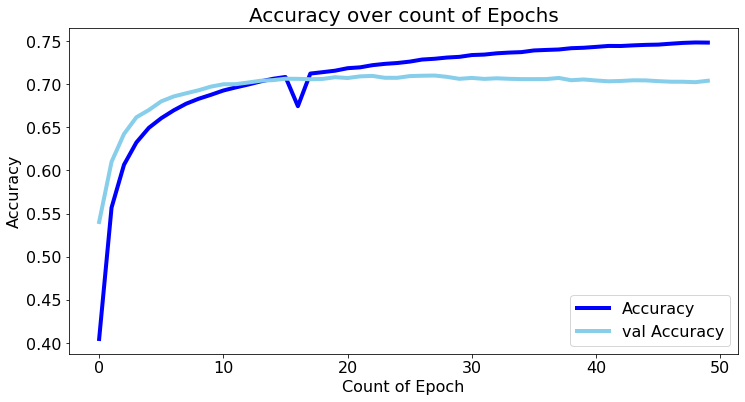

In [29]:
### Combine both plots

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=4, color='blue')
plt.plot(history.history['val_accuracy'], label='val Accuracy', lw=4, color = 'skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


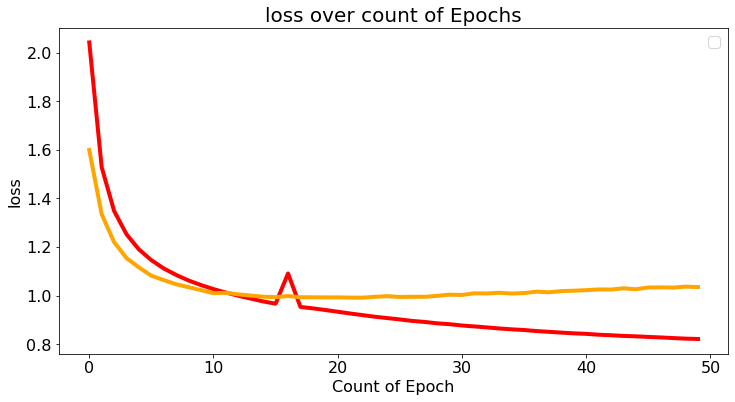

In [30]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=4, color='red')
plt.plot(history.history['val_loss'], lw=4, color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

### 10. Loading my pre-trained weights to resume training

In [ ]:
# Instantiate my new model
model_ckpt2 = create_model()

# load the saved weights into my instantiated model
#
model_ckpt2.load_weights(filepath)

In [ ]:
# resume the training

model_ckpt2.fit(X_train, y_train, batch_size=128, epochs=5, validation_data =(X_test, y_test),callbacks=callbacks))

In [ ]:
train_Loss, train_Accuracy = model_ckpt2.evaluate(X_train, y_train, verbose=2)

In [ ]:
test_Loss, test_Accuracy = model_ckpt2.evaluate(X_test, y_test, verbose=2)

### 11.Try generating text using help from keras.io

In [ ]:
### Functions obtained from keras.io to help te
### to help predict the

IndentationError: ignored

In [31]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [32]:

def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [33]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [34]:
print(generate_text(500, 0.2))

thon is for you  think no more  this first course took me step by step in learning the very basic of python                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             


In [35]:
print(generate_text(500, 1))

ing forums  i also loved the website  py e com  overall  i loved this class and look forward to learn mpstatics for clearly explains very gres using python  i would recommend student that werrear possible  with the syntabients  so tried at the halferily for providing  mifient to had study  i was like like me i hope that javager the instructor with computerts in the smullibly first course get you teach were very section to review i can understand learning platform     data scripcintimal prior knowledge of coding  i dis worth zeroor even thanking shows org every beginners and this course courses


In [36]:
print(generate_text(1000, 0.2))

ake in certain programs and clarifies that for students very well before  overall learning online experience                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [37]:
print(generate_text(1000, 1))

one who s interested     this course is very helpful and anyone can do this  as its name says programming worle  this course helged in getting until yours elfols all the way use    more professor de lovely done m coursey  he explains each and i started to teaching time learning python  i would like to thank professor      this is frustatting the material is process the course for a programming experience with an absolutely giving ole the professor is really becomp of this internde with the last i don t me lister to get the learning projects these much siruction there with no prior knowledge to developer  officely implesty and the instructor coufle even on computers and the way and bul the one is very python programming language in you sure if you have can techor introductory and the instructor was really for your for you  this course helped me in programming      thr prof  for learning the learners of the perspees the student to understand this course       even for peri in other cours

In [39]:
generated1 = generate_text(1000, 1)

In [38]:
from textblob import TextBlob

In [40]:
b = TextBlob(generated1)
b.correct()

TextBlob(" to continue the program to learn more   this course is just wonderful for a newby like me  know nothing but this would be knee  one of the teachers easy to understand learning experience in the teacher and it s what saddles self had across for beginning this is an entialliegh easy to understand  the owntration  i m really fornusively and understand skirmishing part for best to do show more provides it s comenique reached with programming skill  enjoyageding to continue to learn this loop  thank about at the processes about programming and fun  since the basic to only helpful  but i can t revieivers by the introsick   starting and it was just  but stretched with easily understanding   slogan so should about less a bit afrecors so much the very prefer to most us that makes he has to think a fun a little bast interesting   i would kind mr the things from these fertutions i din s behind the lessons to continue learning the programming and programming for this work coming  online

In [41]:
from autocorrect import Speller
check = Speller(lang='en')
check(generated1)

ModuleNotFoundError: ignored